### Notebook to create the simplified FOM producer for cluster implementation

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [2]:
# load in data for merging
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)


Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.24 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.56 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.75 %
Absolute Cut efficiency:
Efficiency: 7.61 %


In [3]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/


Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


In [8]:
def histogram_fit(fnc, sig_data, binning, p0, fit_labels, bounds = []):
    '''
    fit a function from histogram data, return the fitting parameters
    '''


    # Use positron data to collect the C1 and C2 values from the signal fit
    s_cnts, s_edges, s_patches = func.plot_hist(sig_data, binning = binning, log = False, data = True)

    
    s_centres = shift_to_bin_centers(s_edges)

    # FIT
    if (bounds == []):
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000)
    else:
        return curve_fit(fnc, s_centres, s_cnts, p0, maxfev = 500000, bounds = bounds)

def fom_calc_MC(cut_data, positron_data, cut_list, binning = 80, verbose = False):
    '''
        calculate FOM via fitting using MC information for C1 and C2
        start the cut list at non-zero. eg cut_list = [0.1, 0.2, ...]
    '''
    # preset some parameters for sanity purposes
    emin = 1.5
    emax = 1.7


    # select only events in which events have positrons
    sig_data = cut_data[cut_data['event'].isin(positron_data['event_id'].to_numpy())]
    bck_data = cut_data[~cut_data['event'].isin(positron_data['event_id'].to_numpy())]


    print("Obtaining C1 and C2")
    #####            C1 AND C2 ACQUISITION          #####
    # p0 is apriori
    p0 = ([1, 1, 1.58, 0.3, 0.8, 0])
    fit_labels = ['B1', 'A', 'mu', 'sigma', 'C1', 'C2']
    
    # fit the histogram
    s_popt, s_pcov = histogram_fit(func.sig_func, sig_data, binning, p0, fit_labels)

    
    if (verbose == True):
        print("=========================== SIGNAL FIT ============================")
        func.plot_fit(func.sig_func, np.linspace(emin, emax, 1000), s_popt, fit_labels)
        func.plot_hist(sig_data, binning = 80, title='Signal fit', log = False)
        plt.show()
        func.print_parameters(s_popt, s_pcov, fit_labels)
    
    # Set C1 and C2
    C1 = s_popt[4]
    C2 = s_popt[5]

    # C1 and C2 control
    if (C1 < 0):
        C1 = 0
    if (C2 < 0):
        C2 = 0

    print("C1: {}, C2: {}".format(C1, C2))



    #####           MU AND SIGMA ACQUISITION            #####

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']

    # collect histogram information

    #cnt, edges, patches = func.plot_hist(cut_data, binning = binning, log = False, data = True)
    # fit
    #g_popt, g_pcov = curve_fit(func.gauss, centres, cnts, g_p0, maxfev = 500000)
    g_popt, g_pcov = histogram_fit(func.gauss, cut_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("mu: {}, sigma: {}".format(mu, sigma))

    if (verbose == True):
        print("=========================== GAUSSIAN FIT ============================")
        func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
        func.plot_hist(cut_data, binning = 80, title='Gauss fit', log = False)
        plt.show()
        func.print_parameters(g_popt, g_pcov, g_labels)


    #####          NS AND NB ACQUISITION                #####

    fixed_sig_bck_func = lambda x, ns, a, nb, tau: func.sig_bck_func(x, ns, a, mu, sigma, C1, C2, nb, tau)

    # apriori
    sb_p0 = [400, 1, 20, 0.1]
    sb_labels = ['ns', 'a', 'nb', 'tau']

    # fit
    sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, cut_data, binning, sb_p0, sb_labels)
    #sb_popt, sb_pcov = curve_fit(fixed_sig_bck_func, centres, cnts, sb_p0, maxfev = 500000)
    # take bin widths to calculate number of events
    _, edges, _ =func.plot_hist(cut_data, binning = binning, log = False, data = True)
    bin_width = edges[1] - edges[0]
    ns0 = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
    nb0 = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

    if (verbose == True):

        print("=========================== FULL FIT ============================")
        func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
        func.plot_hist(cut_data, binning = 80, title='Full fit', log = False)
        plt.show()
        func.print_parameters(sb_popt, sb_pcov, sb_labels)

        print('ns0      = {}'.format(ns0[0]))
        print('nb0      = {}'.format(nb0[0]))
        print("total    = {:.0f}".format(ns0[0]+nb0[0]))
        print("Event no = {}".format(len(cut_data.index)))
    
    
    # create list for fom values
    e       = []
    b       = []
    fom     = []
    fom_err = []
    e_err = []
    b_err = []


    # wipe variables to stop variable bleed over
    del g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, bin_width

    for i in range(len(cut_list)):
        if (verbose == True):
            print("=========================== ====================== ===========================")
            print("=========================== BLOB 2 CUT STARTS HERE ===========================")
            print("=========================== ====================== ===========================")
        print("Applying cut {} MeV".format(cut_list[i]))

        blob_data = cut_data[(cut_data['eblob2'] > cut_list[i])]

        # collect gaussian peak
        g_popt, g_pcov = histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
        # set mu and sigma
        mu      = g_popt[1]
        sigma   = g_popt[2]

        if (verbose == True):
            print("=========================== GAUSSIAN FIT ============================")
            func.plot_fit(func.gauss, np.linspace(emin, emax, 1000), g_popt, g_labels)
            func.plot_hist(blob_data, binning = 80, title='Gauss fit', log = False)
            plt.show()
            func.print_parameters(g_popt, g_pcov, g_labels)


        # collect nb and ns
        sb_popt, sb_pcov = histogram_fit(fixed_sig_bck_func, blob_data, binning, sb_p0, sb_labels, bounds = ([0, -np.inf, 0, -np.inf],[np.inf, np.inf, np.inf, np.inf]))
        # take bin widths to calculate number of events
        _, edges, _ =func.plot_hist(blob_data, binning = binning, log = False, data = True, output = False)
        bin_width = edges[1] - edges[0]
        ns = quad(func.sig_func, emin, emax, args = (sb_popt[0],sb_popt[1], mu, sigma, C1, C2))/bin_width
        nb = quad(func.bck_func, emin, emax, args = (sb_popt[2], sb_popt[3]))/bin_width

        if (verbose == True):

            print("=========================== FULL FIT ============================")
            func.plot_fit(fixed_sig_bck_func, np.linspace(emin, emax, 1000), sb_popt, sb_labels)
            func.plot_hist(blob_data, binning = 80, title='Full fit', log = False)
            plt.show()
            func.print_parameters(sb_popt, sb_pcov, sb_labels)

            print('ns - {}'.format(ns[0]))
            print('nb - {}'.format(nb[0]))
            print("total = {:.0f}".format(ns[0]+nb[0]))
            print("Event no = {}".format(len(blob_data.index)))
        
        e_check = ns[0]/ns0[0]
        b_check = nb[0]/nb0[0]
        fom_check = e_check/np.sqrt(b_check)

        e.append(e_check)
        b.append(b_check)
        fom.append(fom_check)

        # errors for fom
        e_err.append(func.ratio_error(e[i],ns[0],ns0[0],np.sqrt(ns[0]),np.sqrt(ns0[0])))
        b_err.append(func.ratio_error(b[i],nb[0],nb0[0],np.sqrt(nb[0]),np.sqrt(nb0[0])))
        fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

        # wipe variables here
        del blob_data, g_popt, g_pcov, mu, sigma, sb_popt, sb_pcov, ns, nb, bin_width, e_check, b_check, fom_check
    
    return (fom, fom_err)



In [75]:
cut_list = np.linspace(0,0.6, 61)
print(cut_list)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6 ]


Obtaining C1 and C2
=========================== SIGNAL FIT ============================


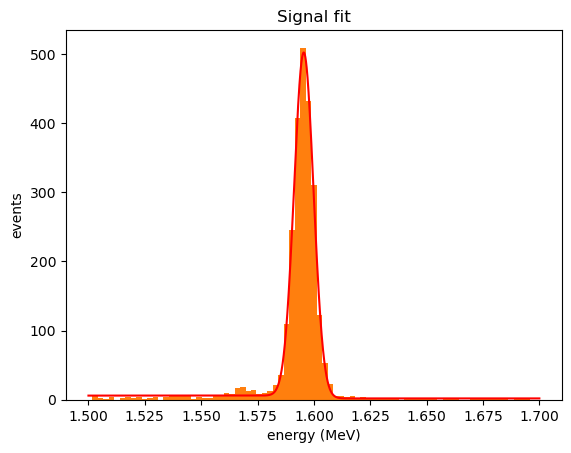

        Fitting output      
B1: 5.3794 ± 1.9020
A: 0.0176 ± 136.1038
mu: 1.5955 ± 0.4677
sigma: 0.0043 ± 0.0079
C1: 0.3779 ± 0.1569
C2: 0.3520 ± 0.2115
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
=========================== GAUSSIAN FIT ============================


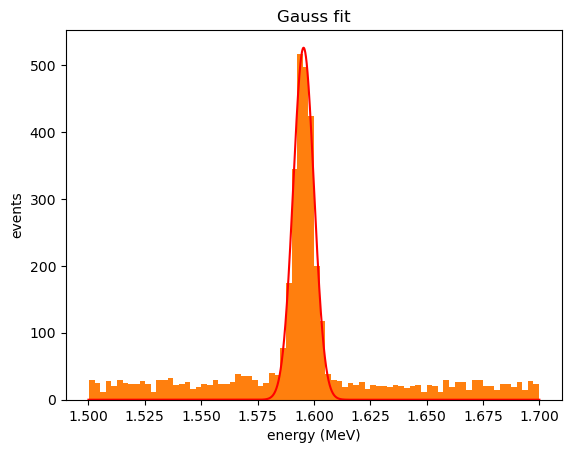

        Fitting output      
A: 525.6724 ± 16.2472
mu: 1.5954 ± 0.0002
sigma: 0.0046 ± 0.0002
=========================== FULL FIT ============================


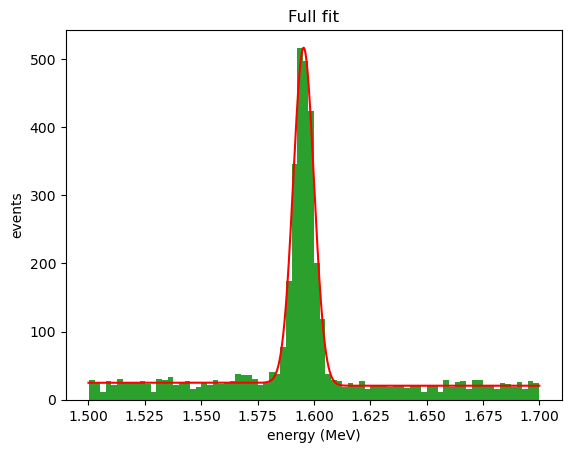

        Fitting output      
ns: 5.6850 ± 0.0620
a: 0.0087 ± 0.0184
nb: 18.5504 ± 28.2010
tau: 778825.2358 ± 311921962959.5612
ns0      = 2602.6364349512705
nb0      = 1486.627221175132
total    = 4089
Event no = 4086
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.1 MeV
=========================== GAUSSIAN FIT ============================


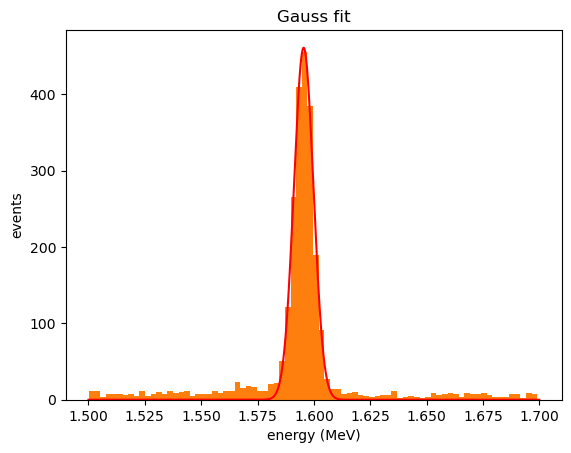

        Fitting output      
A: 461.0978 ± 6.5797
mu: 1.5954 ± 0.0001
sigma: 0.0043 ± 0.0001
=========================== FULL FIT ============================


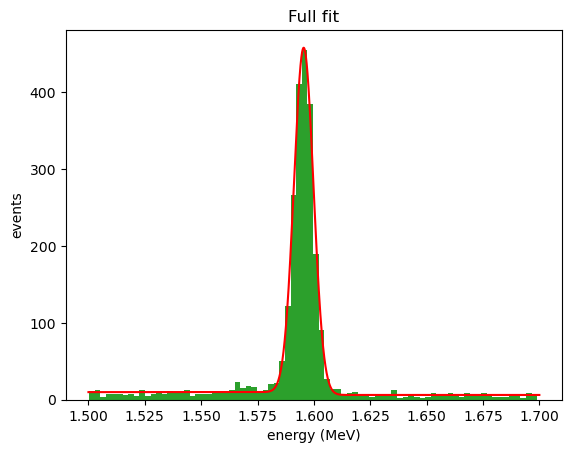

        Fitting output      
ns: 4.8795 ± 0.0320
a: 0.0082 ± 0.0114
nb: 4.4848 ± 15.3797
tau: 182938.6191 ± 71655867506.3930
ns - 2243.3730541093246
nb - 360.93457651082406
total = 2604
Event no = 2601
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.2 MeV
=========================== GAUSSIAN FIT ============================


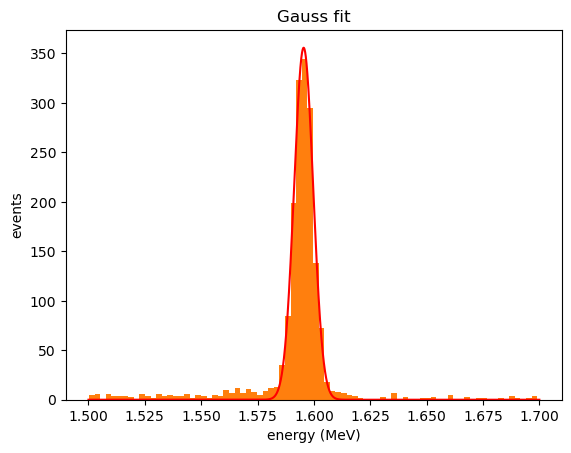

        Fitting output      
A: 355.8036 ± 4.0095
mu: 1.5954 ± 0.0001
sigma: 0.0042 ± 0.0001
=========================== FULL FIT ============================


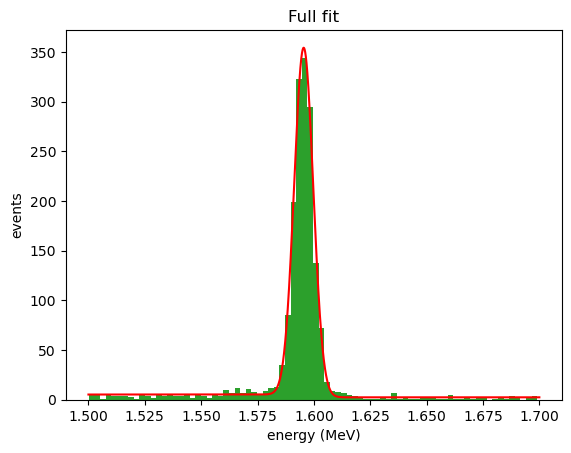

        Fitting output      
ns: 3.7122 ± 0.0262
a: 0.0080 ± 0.0125
nb: 1.1146 ± 11.8498
tau: 87437.8174 ± 50754864630.5159
ns - 1706.7113301884644
nb - 89.70223084731454
total = 1796
Event no = 1795
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.3 MeV
=========================== GAUSSIAN FIT ============================


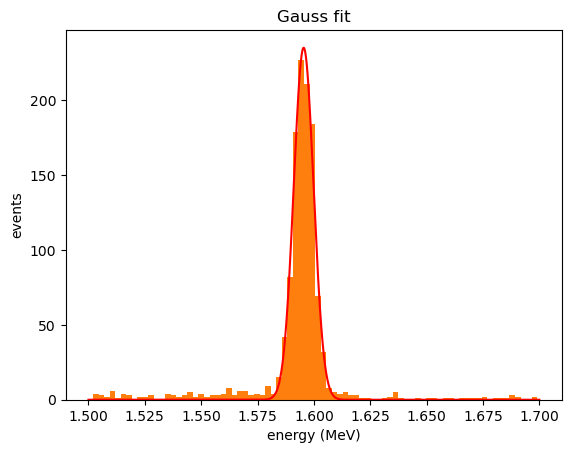

        Fitting output      
A: 235.2139 ± 3.3288
mu: 1.5955 ± 0.0001
sigma: 0.0044 ± 0.0001
=========================== FULL FIT ============================


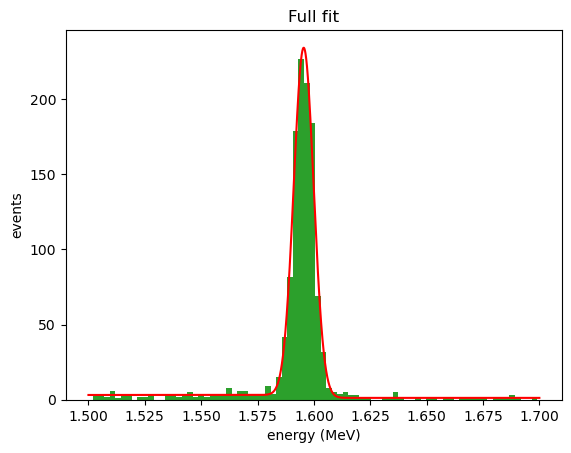

        Fitting output      
ns: 2.5625 ± 0.0276
a: 0.0083 ± 0.0183
nb: 0.3235 ± 13.4574
tau: 3648.5645 ± 345590076.1689
ns - 1188.8001497547616
nb - 26.259753890396162
total = 1215
Event no = 1212
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.4 MeV
=========================== GAUSSIAN FIT ============================


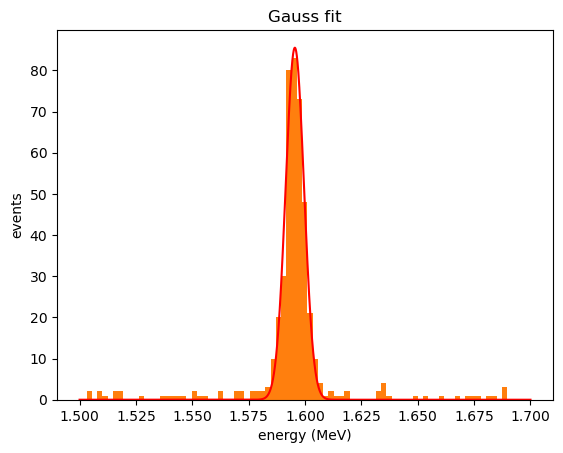

        Fitting output      
A: 85.5160 ± 1.5568
mu: 1.5955 ± 0.0001
sigma: 0.0041 ± 0.0001
=========================== FULL FIT ============================


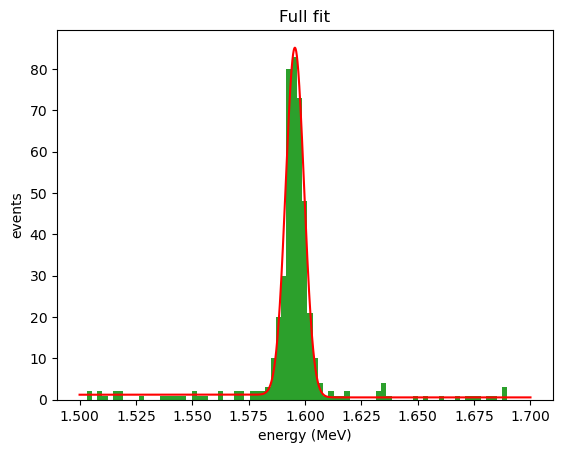

        Fitting output      
ns: 0.8591 ± 0.0126
a: 0.0077 ± 0.0251
nb: 0.2603 ± 6.5758
tau: 49591.2269 ± 38866947047.8340
ns - 420.7700763637661
nb - 22.317928173887967
total = 443
Event no = 439
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.5 MeV
=========================== GAUSSIAN FIT ============================


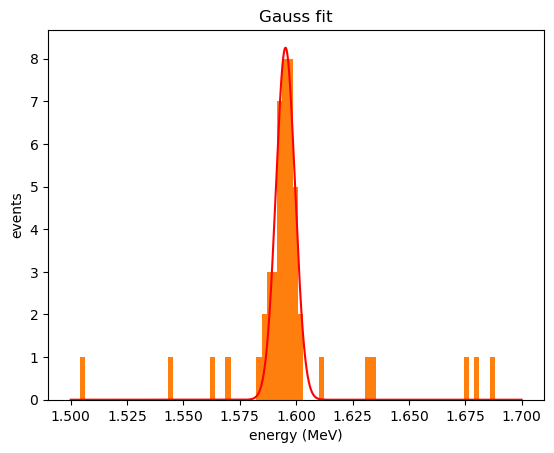

        Fitting output      
A: 8.2555 ± 0.3148
mu: 1.5953 ± 0.0002
sigma: 0.0042 ± 0.0002
=========================== FULL FIT ============================


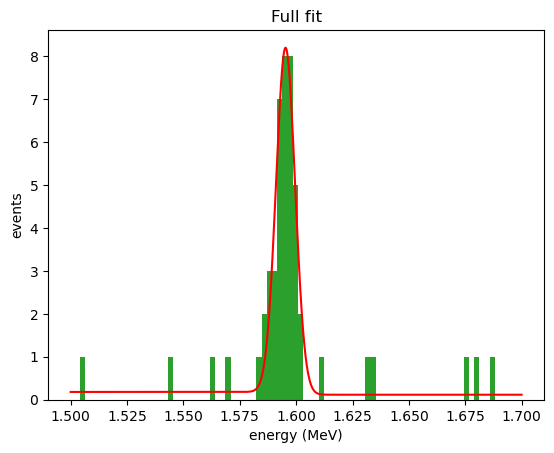

        Fitting output      
ns: 0.0854 ± 0.0027
a: 0.0080 ± 0.0542
nb: 0.0865 ± 0.0524
tau: -167153.9722 ± 0.0000
ns - 42.40710492874669
nb - 7.521517393134626
total = 50
Event no = 49
=========================== ====================== ===========================
=========================== BLOB 2 CUT STARTS HERE ===========================
=========================== ====================== ===========================
Applying cut 0.6 MeV
=========================== GAUSSIAN FIT ============================


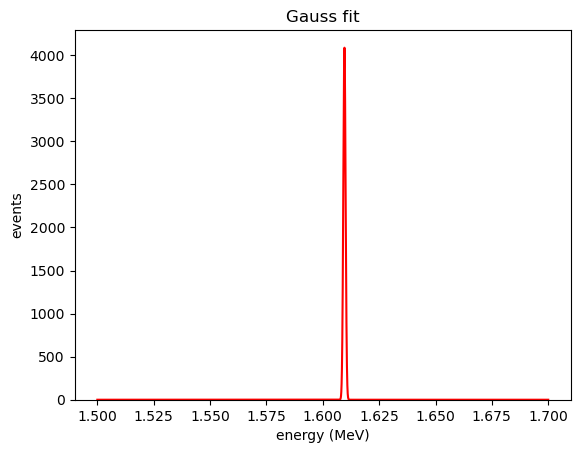

        Fitting output      
A: 4086.5779 ± nan
mu: 1.6096 ± nan
sigma: 0.0005 ± nan
=========================== FULL FIT ============================


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1402: RuntimeWarning: invalid value encountered in sqrt
  print("{}: {:.4f} \u00B1 {:.4f}".format(labels[i], popt[i], np.sqrt(pcov[i][i]) )) # taking diagonal covariances as errors


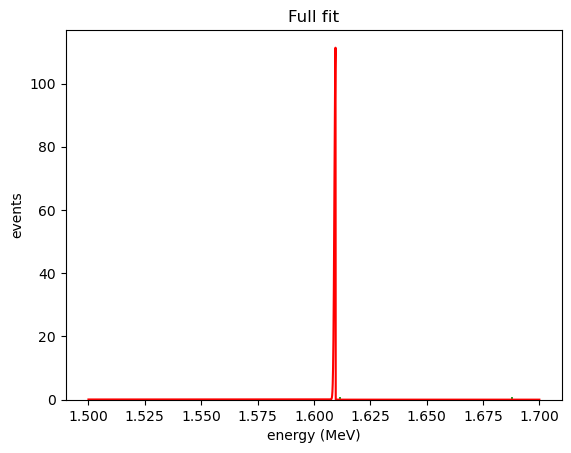

        Fitting output      
ns: 0.0710 ± 4149.3352
a: -56.2397 ± 0.0011
nb: 0.0000 ± 1420.6813
tau: 7.5685 ± 490866853.5859
ns - 85.05378950160073
nb - 0.0047057881444120975
total = 85
Event no = 2


In [76]:
cut_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list, verbose = True)

Obtaining C1 and C2
C1: 0.37792968058787235, C2: 0.3519561034730971
mu: 1.5954169538727059, sigma: 0.004595281255864209
Applying cut 0.01 MeV
Applying cut 0.02 MeV
Applying cut 0.03 MeV
Applying cut 0.04 MeV
Applying cut 0.05 MeV
Applying cut 0.060000000000000005 MeV
Applying cut 0.06999999999999999 MeV
Applying cut 0.08 MeV
Applying cut 0.09 MeV
Applying cut 0.09999999999999999 MeV
Applying cut 0.11 MeV
Applying cut 0.12 MeV
Applying cut 0.13 MeV
Applying cut 0.14 MeV
Applying cut 0.15000000000000002 MeV
Applying cut 0.16 MeV
Applying cut 0.17 MeV
Applying cut 0.18000000000000002 MeV
Applying cut 0.19 MeV
Applying cut 0.2 MeV
Applying cut 0.21000000000000002 MeV
Applying cut 0.22 MeV
Applying cut 0.23 MeV
Applying cut 0.24000000000000002 MeV
Applying cut 0.25 MeV
Applying cut 0.26 MeV
Applying cut 0.27 MeV
Applying cut 0.28 MeV
Applying cut 0.29000000000000004 MeV
Applying cut 0.3 MeV
Applying cut 0.31 MeV
Applying cut 0.32 MeV
Applying cut 0.33 MeV
Applying cut 0.34 MeV
Applying cut 

/tmp/ipykernel_26618/3968410918.py:180: RuntimeWarning: divide by zero encountered in double_scalars
  fom_check = e_check/np.sqrt(b_check)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1293: RuntimeWarning: invalid value encountered in double_scalars
  f_error = f*np.sqrt((a_error/a)**2 +(b_error/b)**2)
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1313: RuntimeWarning: divide by zero encountered in double_scalars
  element_1 = np.square(a_error/np.sqrt(b))


Applying cut 0.59 MeV
Applying cut 0.6 MeV
Applying cut 0.61 MeV


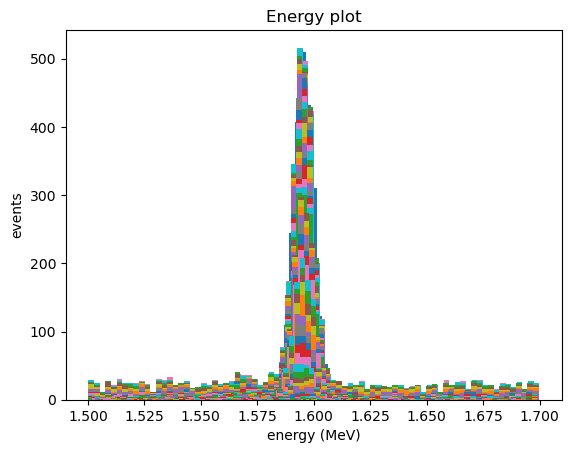

In [9]:
cut_list = np.linspace(0.01,0.61, 61)
fom_out = fom_calc_MC(cut_tracks[0], pos_events, cut_list)

In [78]:
print(fom_out)

[1.7493422692404823, 1.8223077826332161, 1.964300680974419, 2.0419731282879887, 2.1135394484402292, 2.2628363189326235, 2.4150720636442644, 2.4827876402429125, 2.579658325631556, 2.588935706092938, 2.588197857855073, 2.6063968459292024, 2.77066110542294, 2.760058787641245, 2.783267759028567, 2.8020475197966492, 2.906930636015827, 2.9893448139317043, 3.1854745814008503, 3.1843680397219005, 3.2325769769247885, 3.4775894133616467, 3.610710916597145, 3.596415886326084, 3.8912783777917936, 4.899984397652057, 4.75372011891728, 5.435959711092917, 4.638873245723903, 4.211106448620478, 3.3605012591086565, 2.597024226875685, 2.4104075546676764, 2.592665148161727, 1.6464251146218962, 1.40653694599933, 1.2439421068047345, 2.0057251285598037, 1.630021480803803, 1.324605376209008, 1.1693100933627307, 2.3676968321537717, 1.2960703556494588, 1.114106572143703, 1.044856590702774, 1.1151460581891017, 0.4808949564832762, 0.22907274911749612, 0.22768920668634268, 0.23581665740007315, 0.17136969092697069, 

Text(0, 0.5, 'fom')

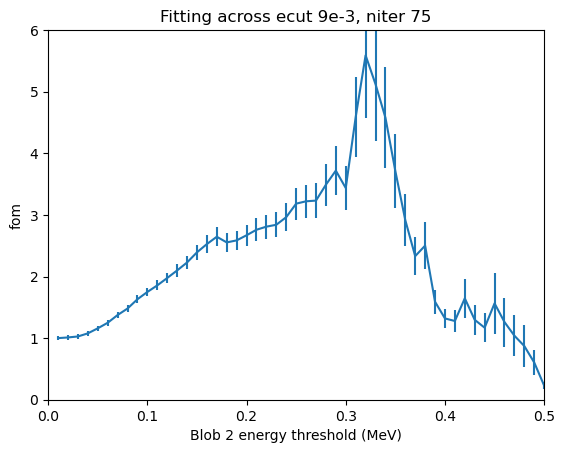

In [10]:
plt.errorbar(cut_list, fom_out[0], yerr = fom_out[1])
plt.title("Fitting across ecut 9e-3, niter 75")
plt.xlabel("Blob 2 energy threshold (MeV)")
plt.xlim([0,0.5])
plt.ylim([0,6])
plt.ylabel("fom")

In [12]:
np.save('fittingfom.npy', fom_out)
np.save('blob2vals.npy', cut_list)